
Simulating regional traffic for weather: Rain, holiday: False
Analyzing 63 taxi stands in the region...


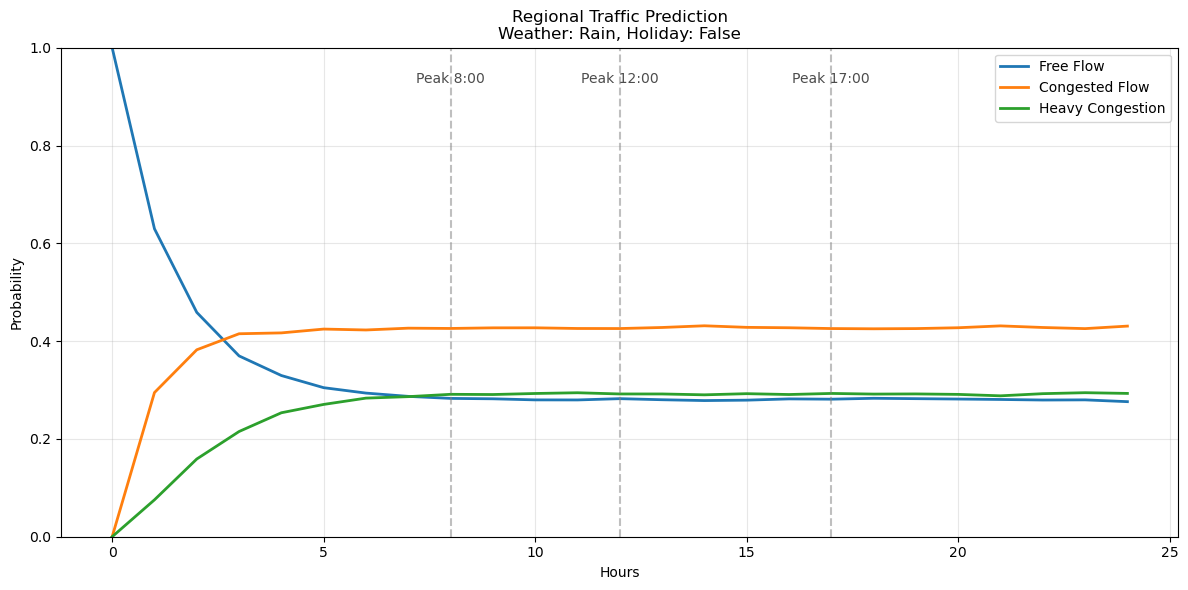


Regional Traffic Summary:
Free Flow: Avg 33.8%, Max 100.0% at hour 0
Congested Flow: Avg 40.2%, Max 43.1% at hour 14
Heavy Congestion: Avg 26.0%, Max 29.5% at hour 23


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Define possible traffic states and base transition matrix
traffic_states = ['Free Flow', 'Congested Flow', 'Heavy Congestion']

base_transition_matrix = {
    'Free Flow': {'Free Flow': 0.7, 'Congested Flow': 0.25, 'Heavy Congestion': 0.05},
    'Congested Flow': {'Free Flow': 0.2, 'Congested Flow': 0.6, 'Heavy Congestion': 0.2},
    'Heavy Congestion': {'Free Flow': 0.1, 'Congested Flow': 0.3, 'Heavy Congestion': 0.6}
}

def adjust_matrix(weather: str, holiday: bool):
    """Adjust transition probabilities based on weather and holiday conditions"""
    weather_mod = {'Clear': 1.0, 'Rain': 0.9, 'Snow': 0.7}.get(weather, 1.0)
    holiday_mod = 0.9 if holiday else 1.0

    adjusted = {}
    for from_state in traffic_states:
        base = base_transition_matrix[from_state].copy()
        
        if from_state == 'Free Flow':
            base['Free Flow'] *= weather_mod * holiday_mod
            remainder = 1.0 - base['Free Flow']
            base['Congested Flow'] = remainder * 0.8
            base['Heavy Congestion'] = remainder * 0.2
        elif from_state == 'Congested Flow':
            base['Free Flow'] *= weather_mod * holiday_mod
            base['Heavy Congestion'] *= (1.0 / weather_mod)
            # Normalize probabilities
            total = sum(base.values())
            base = {k: v / total for k, v in base.items()}
        elif from_state == 'Heavy Congestion':
            base['Free Flow'] *= weather_mod * holiday_mod
            # Normalize probabilities
            total = sum(base.values())
            base = {k: v / total for k, v in base.items()}
        
        adjusted[from_state] = base

    return adjusted

def monte_carlo_simulation(current_state, weather, holiday, steps=10, num_simulations=1000):
    """Run Monte Carlo simulation of traffic state transitions"""
    results = []
    transition_matrix = adjust_matrix(weather, holiday)
    
    for _ in range(num_simulations):
        state_sequence = [current_state]
        for _ in range(steps):
            current = state_sequence[-1]
            next_state = np.random.choice(
                list(transition_matrix[current].keys()),
                p=list(transition_matrix[current].values())
            )
            state_sequence.append(next_state)
        results.append(state_sequence)

    # Calculate state probabilities at each time step
    state_counts = defaultdict(lambda: [0] * (steps + 1))
    for seq in results:
        for i, state in enumerate(seq):
            state_counts[state][i] += 1

    state_probs = {
        state: [count / num_simulations for count in counts]
        for state, counts in state_counts.items()
    }

    # Ensure all states are represented even if they never occurred
    for state in traffic_states:
        if state not in state_probs:
            state_probs[state] = [0.0] * (steps + 1)

    return state_probs

def calculate_region_traffic(df, weather, holiday, steps=10, num_simulations=500):
    """Calculate aggregated traffic probabilities for all stands in the region"""
    all_probs = {state: np.zeros(steps + 1) for state in traffic_states}
    
    for _, row in df.iterrows():
        stand_probs = monte_carlo_simulation(
            current_state='Free Flow',
            weather=weather,
            holiday=holiday,
            steps=steps,
            num_simulations=num_simulations
        )
        
        for state in traffic_states:
            all_probs[state] += np.array(stand_probs[state])
    
    # Average the probabilities across all stands
    num_stands = len(df)
    for state in traffic_states:
        all_probs[state] /= num_stands
    
    return all_probs

def main():
    # Load data from CSV file
    try:
        df = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
    except FileNotFoundError:
        print("Error: CSV file not found. Please ensure 'metaData_taxistandsID_name_GPSlocation.csv' is in the same directory.")
        return
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return

    # Verify required columns exist
    required_columns = ['ID', 'Descricao', 'Latitude', 'Longitude']
    if not all(col in df.columns for col in required_columns):
        print("Error: CSV file is missing required columns. Needed columns are: ID, Descricao, Latitude, Longitude")
        return

    # Simulation parameters
    steps = 24  # Now showing 24 hours for daily pattern
    simulations = 1000  # Increased simulations for better accuracy
    
    # Select weather and holiday conditions for the entire region
    weather = random.choice(['Clear', 'Rain', 'Snow'])
    holiday = random.choice([True, False])
    
    print(f"\nSimulating regional traffic for weather: {weather}, holiday: {holiday}")
    print(f"Analyzing {len(df)} taxi stands in the region...")
    
    # Calculate regional traffic probabilities
    region_probs = calculate_region_traffic(df, weather, holiday, steps, simulations)
    
    # Plot regional traffic prediction
    plt.figure(figsize=(12, 6))
    for state in traffic_states:
        plt.plot(range(steps + 1), region_probs[state], label=state, linewidth=2)
    
    plt.title(f"Regional Traffic Prediction\nWeather: {weather}, Holiday: {holiday}")
    plt.xlabel("Hours")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add peak hour indicators
    peak_hours = [8, 12, 17]  # Morning, noon, and evening peaks
    for hour in peak_hours:
        plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)
        plt.text(hour, 0.95, f'Peak {hour}:00', ha='center', va='top', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nRegional Traffic Summary:")
    for state in traffic_states:
        avg_prob = np.mean(region_probs[state])
        max_prob = np.max(region_probs[state])
        max_hour = np.argmax(region_probs[state])
        print(f"{state}: Avg {avg_prob:.1%}, Max {max_prob:.1%} at hour {max_hour}")

if __name__ == "__main__":
    main()


Prediction Conditions:
Weather: Clear, Time: Evening, Taxi Density: High


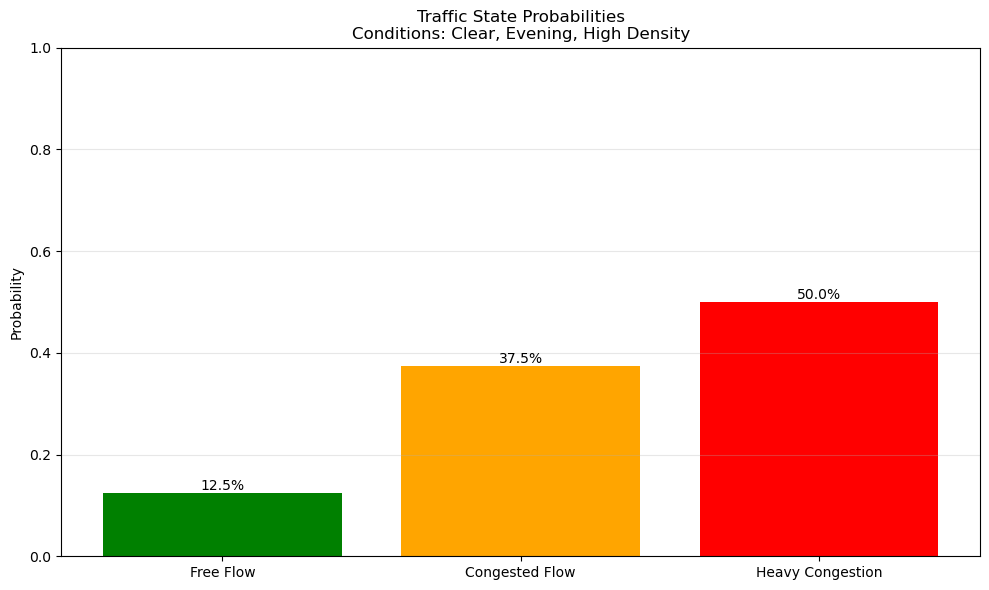


Predicted Traffic State Probabilities:
Free Flow: 12.5%
Congested Flow: 37.5%
Heavy Congestion: 50.0%


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Traffic states
TRAFFIC_STATES = ['Free Flow', 'Congested Flow', 'Heavy Congestion']
TIME_BINS = ['Night', 'Morning', 'Afternoon', 'Evening']

class TrafficPredictor:
    def __init__(self):
        # Base transition matrices for different conditions
        self.base_matrix = {
            'Free Flow': {'Free Flow': 0.7, 'Congested Flow': 0.25, 'Heavy Congestion': 0.05},
            'Congested Flow': {'Free Flow': 0.2, 'Congested Flow': 0.6, 'Heavy Congestion': 0.2},
            'Heavy Congestion': {'Free Flow': 0.1, 'Congested Flow': 0.3, 'Heavy Congestion': 0.6}
        }
        
        # Modifiers for different conditions
        self.weather_mod = {'Clear': 1.0, 'Rain': 0.8, 'Snow': 0.6}
        self.time_mod = {
            'Night': 1.2,    # Better flow at night
            'Morning': 0.7,  # Worse in morning rush
            'Afternoon': 0.9,
            'Evening': 0.75  # Worse in evening rush
        }
        self.density_mod = {
            'Low': 1.2,
            'Medium': 1.0,
            'High': 0.8
        }
    
    def get_time_of_day(self):
        """Categorize current time into time bins"""
        hour = datetime.now().hour
        if 5 <= hour < 10: return 'Morning'
        elif 10 <= hour < 15: return 'Afternoon'
        elif 15 <= hour < 20: return 'Evening'
        else: return 'Night'
    
    def get_taxi_density(self, df):
        """Estimate density based on number of taxis in region"""
        num_taxis = len(df)
        if num_taxis < 10: return 'Low'
        elif num_taxis < 20: return 'Medium'
        else: return 'High'
    
    def build_transition_matrix(self, weather, time_of_day, density):
        """Build dynamic transition matrix based on conditions"""
        matrix = {}
        weather_factor = self.weather_mod.get(weather, 1.0)
        time_factor = self.time_mod.get(time_of_day, 1.0)
        density_factor = self.density_mod.get(density, 1.0)
        combined_factor = weather_factor * time_factor * density_factor
        
        for from_state in TRAFFIC_STATES:
            adjusted = {}
            total = 0
            
            for to_state in TRAFFIC_STATES:
                base_prob = self.base_matrix[from_state][to_state]
                
                # Apply modifiers based on state transitions
                if from_state == 'Free Flow' and to_state != 'Free Flow':
                    adjusted_prob = base_prob * (1/combined_factor)
                elif from_state != 'Heavy Congestion' and to_state == 'Heavy Congestion':
                    adjusted_prob = base_prob * (1/combined_factor)
                else:
                    adjusted_prob = base_prob * combined_factor
                
                adjusted[to_state] = adjusted_prob
                total += adjusted_prob
            
            # Normalize probabilities
            matrix[from_state] = {k: v/total for k, v in adjusted.items()}
        
        return matrix
    
    def predict(self, df, steps=24, num_simulations=1000):
        """Predict traffic flow using Markov chain simulation"""
        weather = random.choice(['Clear', 'Rain', 'Snow'])
        time_of_day = self.get_time_of_day()
        density = self.get_taxi_density(df)
        
        print(f"\nPrediction Conditions:")
        print(f"Weather: {weather}, Time: {time_of_day}, Taxi Density: {density}")
        
        transition_matrix = self.build_transition_matrix(weather, time_of_day, density)
        current_state = 'Free Flow'  # Default starting state
        
        # Run Markov chain simulation
        state_counts = {state: 0 for state in TRAFFIC_STATES}
        current = current_state
        
        for _ in range(steps):
            next_state = np.random.choice(
                list(transition_matrix[current].keys()),
                p=list(transition_matrix[current].values())
            )
            state_counts[next_state] += 1
            current = next_state
        
        # Convert counts to probabilities
        total = sum(state_counts.values())
        state_probs = {k: v/total for k, v in state_counts.items()}
        
        # Visualization
        self.plot_results(state_probs, steps, weather, time_of_day, density)
        
        return state_probs
    
    def plot_results(self, probs, steps, weather, time_of_day, density):
        """Visualize the prediction results"""
        plt.figure(figsize=(10, 6))
        
        # Bar plot of state probabilities
        states = list(probs.keys())
        probabilities = list(probs.values())
        
        colors = ['green', 'orange', 'red']
        bars = plt.bar(states, probabilities, color=colors)
        
        # Add probability labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}', ha='center', va='bottom')
        
        plt.title('Traffic State Probabilities\n' +
                 f'Conditions: {weather}, {time_of_day}, {density} Density')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    # Load taxi stand data
    try:
        df = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
    except FileNotFoundError:
        print("Error: CSV file not found. Using sample data instead.")
        data = {
            'ID': range(1, 21),  # Simulating 20 taxis
            'Descricao': [f"Stand_{i}" for i in range(1, 21)],
            'Latitude': np.random.uniform(41.14, 41.19, 20),
            'Longitude': np.random.uniform(-8.67, -8.56, 20)
        }
        df = pd.DataFrame(data)
    
    # Initialize and run predictor
    predictor = TrafficPredictor()
    results = predictor.predict(df)
    
    print("\nPredicted Traffic State Probabilities:")
    for state, prob in results.items():
        print(f"{state}: {prob:.1%}")

In [13]:
import numpy as np

# Define transition matrix (example values)
transition_matrix = {
    'Free Flow': {'Free Flow': 0.7, 'Congested Flow': 0.3, 'Heavy Congestion': 0.0},
    'Congested Flow': {'Free Flow': 0.2, 'Congested Flow': 0.6, 'Heavy Congestion': 0.2},
    'Heavy Congestion': {'Free Flow': 0.1, 'Congested Flow': 0.3, 'Heavy Congestion': 0.6}
}

# Initial state
current_state = 'Free Flow'

# Number of simulations
num_simulations = 1000
simulation_results = []

# Monte Carlo simulation
for _ in range(num_simulations):
    states = [current_state]
    for _ in range(10):  # Simulate 10 time steps
        next_state = np.random.choice(
            list(transition_matrix[states[-1]].keys()),
            p=list(transition_matrix[states[-1]].values())
        )
        states.append(next_state)
    simulation_results.append(states)

# Analyze simulation results
# Calculate the probability of being in each state at each time step
state_probabilities = {
    'Free Flow': [0] * 11,  # 10 time steps + initial state
    'Congested Flow': [0] * 11,
    'Heavy Congestion': [0] * 11
}

for simulation in simulation_results:
    for time_step, state in enumerate(simulation):
        state_probabilities[state][time_step] += 1

# Convert counts to probabilities
for state in state_probabilities:
    for time_step in range(11):
        state_probabilities[state][time_step] /= num_simulations

# Print the results
for time_step in range(11):
    print(f"Time Step {time_step}:")
    for state in state_probabilities:
        print(f"  {state}: {state_probabilities[state][time_step]:.2%}")

Time Step 0:
  Free Flow: 100.00%
  Congested Flow: 0.00%
  Heavy Congestion: 0.00%
Time Step 1:
  Free Flow: 70.70%
  Congested Flow: 29.30%
  Heavy Congestion: 0.00%
Time Step 2:
  Free Flow: 54.90%
  Congested Flow: 39.50%
  Heavy Congestion: 5.60%
Time Step 3:
  Free Flow: 46.60%
  Congested Flow: 43.50%
  Heavy Congestion: 9.90%
Time Step 4:
  Free Flow: 41.00%
  Congested Flow: 47.40%
  Heavy Congestion: 11.60%
Time Step 5:
  Free Flow: 41.60%
  Congested Flow: 41.70%
  Heavy Congestion: 16.70%
Time Step 6:
  Free Flow: 37.40%
  Congested Flow: 42.40%
  Heavy Congestion: 20.20%
Time Step 7:
  Free Flow: 36.20%
  Congested Flow: 42.30%
  Heavy Congestion: 21.50%
Time Step 8:
  Free Flow: 34.20%
  Congested Flow: 44.80%
  Heavy Congestion: 21.00%
Time Step 9:
  Free Flow: 36.90%
  Congested Flow: 41.80%
  Heavy Congestion: 21.30%
Time Step 10:
  Free Flow: 38.80%
  Congested Flow: 40.70%
  Heavy Congestion: 20.50%
